In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import math
import numpy as np
import networkx as nx

In [2]:
csv_file = "iris"
df = pd.read_csv(csv_file + "_disc.csv")
target = (df.columns).tolist()[-1]
print(target)

class


In [3]:
   
def calculate_entropy(data, target_column):
    total_rows = len(data)
    target_values = data[target_column].unique()
 
    entropy = 0
    for value in target_values:
        # Calculate the proportion of instances with the current value
        value_count = len(data[data[target_column] == value])
        proportion = value_count / total_rows
        entropy -= proportion * math.log2(proportion)
 
    return entropy
 
entropy_outcome = calculate_entropy(df, target)
print(f"Entropy of the dataset: {entropy_outcome}")

Entropy of the dataset: 1.584962500721156


In [4]:
def calculate_entropy(data, target_column): # for each categorical variable
    total_rows = len(data)
    target_values = data[target_column].unique()
 
    entropy = 0
    for value in target_values:
        # Calculate the proportion of instances with the current value
        value_count = len(data[data[target_column] == value])
        proportion = value_count / total_rows
        entropy -= proportion * math.log2(proportion) if proportion != 0 else 0
 
    return entropy
   
def calculate_information_gain(data, feature, target_column):
 
    # Calculate weighted average entropy for the feature
    unique_values = data[feature].unique()
    weighted_entropy = 0
 
    for value in unique_values:
        subset = data[data[feature] == value]
        proportion = len(subset) / len(data)
        weighted_entropy += proportion * calculate_entropy(subset, target_column)
 
    # Calculate information gain
    information_gain = entropy_outcome - weighted_entropy
 
    return information_gain

In [5]:
for column in df.columns[:-1]:
    entropy = calculate_entropy(df, column)
    information_gain = calculate_information_gain(df, column, target)
    print(f"{column} - Entropia: {entropy:.3f}, Gain: {information_gain:.3f}")

sepal_len - Entropy: 1.020, Information Gain: 0.563
sepal_wid - Entropy: 1.042, Information Gain: 0.265
petal_len - Entropy: 1.628, Information Gain: 1.358
petal_wid - Entropy: 1.689, Information Gain: 1.379


In [6]:
def id3(data, target_column, features):
    if len(data[target_column].unique()) == 1:
        return data[target_column].iloc[0]
 
  
    if len(features) == 0:
        return data[target_column].mode().iloc[0]
 
    best_feature = max(features, key=lambda x: calculate_information_gain(data, x, target_column))
 
    tree = {best_feature: {}}
 
    features = [f for f in features if f != best_feature]
 
    for value in data[best_feature].unique():
        subset = data[data[best_feature] == value]
        tree[best_feature][value] = id3(subset, target_column, features)
 
    return tree

In [7]:
columnas = (df.columns).tolist()
variables = columnas[: -1]
clase = columnas[-1]

In [8]:
result = id3(df,target,variables)

In [9]:
print(result)

{'petal_wid': {1: 'Iris-setosa', 2: {'petal_len': {2: {'sepal_len': {2: 'Iris-versicolor', 1: {'sepal_wid': {1: 'Iris-versicolor'}}}}, 3: {'sepal_wid': {2: 'Iris-versicolor', 1: {'sepal_len': {2: 'Iris-versicolor'}}}}}}, 3: {'sepal_wid': {2: {'sepal_len': {2: {'petal_len': {3: 'Iris-virginica'}}, 3: 'Iris-virginica'}}, 1: 'Iris-virginica'}}, 4: 'Iris-virginica'}}


In [10]:
def draw_tree(tree, pos=None, x=0, y=0, layer=1, width=4):
    if pos is None:
        pos = {}
        plt.figure(figsize=(30, 20))  # Aumentar tamaño de figura

    if isinstance(tree, dict):
        node_label = next(iter(tree))
        pos[node_label + f"_{x}_{y}"] = (x, -y)  
        plt.text(x, -y, node_label, fontsize=12, ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.01'))
        if isinstance(tree[node_label], dict):
            num_items = len(tree[node_label])
            middle = num_items // 2
            i = 0
            for subkey, subtree in tree[node_label].items():
                child_x = x + (i - middle) * (width / max(1, np.log(layer + 1)))
                pos, line_label = draw_tree(subtree, pos, child_x, y + 1, layer + 1, width=width/1.5)
                plt.plot([x, child_x], [-y, -(y + 1)], 'k-')
                # Rotar texto si es necesario
                plt.text((x + child_x) / 2, (-y - (y + 1)) / 2, subkey, fontsize=15, color='darkblue', ha='center', rotation=15)
                i += 1
    else:
        pos[str(tree) + f"_{x}_{y}"] = (x, -y)
        plt.text(x, -y, str(tree), fontsize=15, ha='center', va='center',
                 bbox=dict(facecolor='steelblue', edgecolor='black', boxstyle='round,pad=0.01', alpha=0.5))

    return pos, tree

def plot_decision_tree(tree):
    pos, _ = draw_tree(tree)
    plt.title('Árbol de Decisión')
    plt.axis('off')
    plt.show()

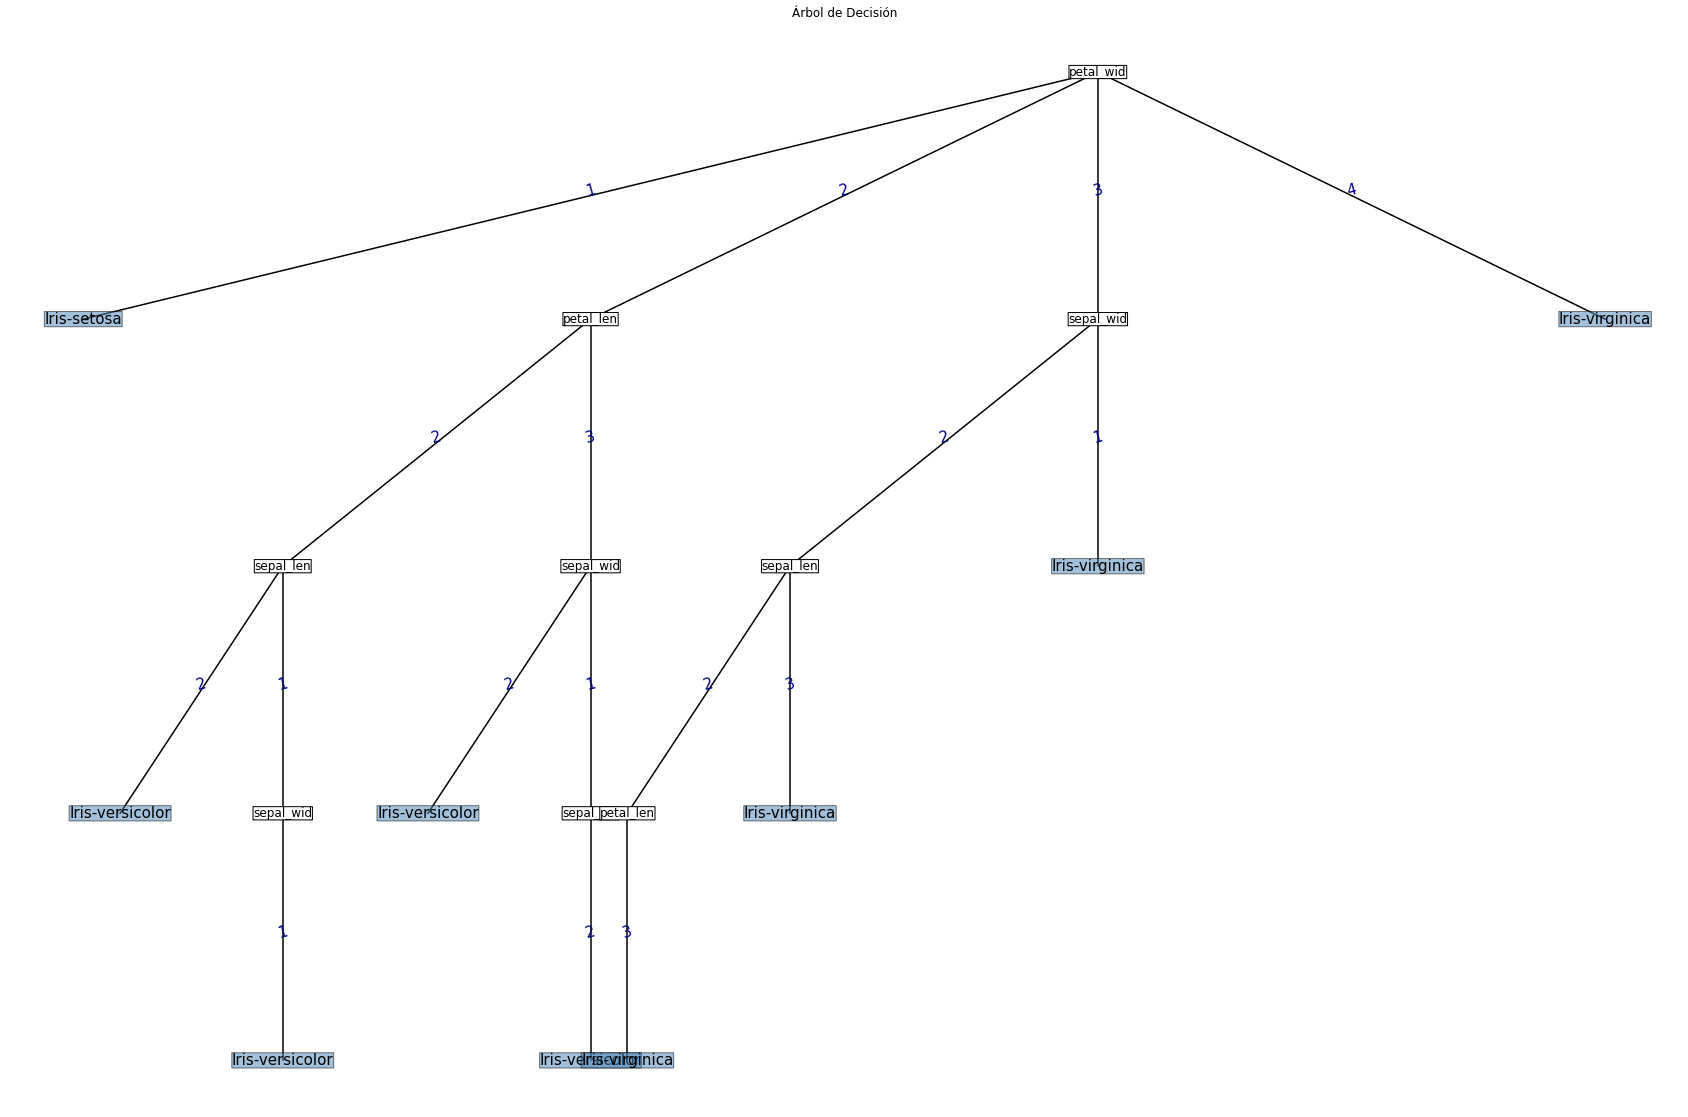

In [11]:
plot_decision_tree(result)

In [12]:
def predict(instance, tree):
    assert isinstance(tree, dict)
    attribute = next(iter(tree))
    while isinstance(tree, dict):
        value = instance[attribute]
        tree = tree[attribute].get(value, np.nan)  # Usa np.nan o alguna etiqueta por defecto si el valor no está en el árbol
        if not isinstance(tree, dict):
            return tree
        attribute = next(iter(tree))

In [13]:
def manual_cross_validation(df, k, stratified=False):
    n_samples = len(df)
    indices = np.arange(n_samples)
    if stratified:
        # Ordena los datos para mantener la proporción de clases en cada pliegue
        sorted_indices = indices[np.argsort(df.iloc[:, -1])]
    else:
        np.random.shuffle(indices)

    fold_sizes = np.full(k, n_samples // k, dtype=int)
    fold_sizes[:n_samples % k] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        if stratified:
            folds.append(sorted_indices[start:stop])
        else:
            folds.append(indices[start:stop])
        current = stop

    accuracy_scores = []
    for i in range(k):
        test_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
        
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]
        
        # Entrenar el árbol de decisión
        tree = id3(train_df, train_df.columns[-1], train_df.columns[:-1])
        
        # Evaluar el árbol entrenado
        predictions = test_df.apply(lambda row: predict(row, tree), axis=1)
        
        # Calcular la precisión
        accuracy = np.mean(predictions == test_df.iloc[:, -1])
        accuracy_scores.append(accuracy)

        # Imprimir las distribuciones de etiquetas
        print(f"Fold {i + 1}: Accuracy = {accuracy}")
        print(f"Distribución etiquetas de entrenamiento:\n{train_df.iloc[:, -1].value_counts()}")
        print(f"Distribución etiquetas de prueba:\n{test_df.iloc[:, -1].value_counts()}\n")
    
    return accuracy_scores, np.mean(accuracy_scores)


In [16]:
accuracy_scores, mean_accuracy = manual_cross_validation(df, 10, stratified=True)
print(f"accuracy vector: {accuracy_scores}")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Standard Deviation of Accuracy: {np.std(accuracy_scores)}")

Fold 1: Accuracy = 1.0
Distribución etiquetas de entrenamiento:
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        35
Name: class, dtype: int64
Distribución etiquetas de prueba:
Iris-setosa    15
Name: class, dtype: int64

Fold 2: Accuracy = 1.0
Distribución etiquetas de entrenamiento:
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        35
Name: class, dtype: int64
Distribución etiquetas de prueba:
Iris-setosa    15
Name: class, dtype: int64

Fold 3: Accuracy = 1.0
Distribución etiquetas de entrenamiento:
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        35
Name: class, dtype: int64
Distribución etiquetas de prueba:
Iris-setosa    15
Name: class, dtype: int64

Fold 4: Accuracy = 0.8666666666666667
Distribución etiquetas de entrenamiento:
Iris-virginica     50
Iris-setosa        45
Iris-versicolor    40
Name: class, dtype: int64
Distribución etiquetas de prueba:
Iris-versicolor    10
Iris-setosa         5
Name: class, dtype: int64

Fold 5: Accuracy = 

In [17]:
accuracy_scores2, mean_accuracy2 = manual_cross_validation(df, 5)
print(f"accuracy vector: {accuracy_scores2}")
print(f"Mean Accuracy: {mean_accuracy2}")
print(f"Standard Deviation of Accuracy: {np.std(accuracy_scores2)}")

Fold 1: Accuracy = 1.0
Distribución etiquetas de entrenamiento:
Iris-versicolor    41
Iris-virginica     41
Iris-setosa        38
Name: class, dtype: int64
Distribución etiquetas de prueba:
Iris-setosa        12
Iris-versicolor     9
Iris-virginica      9
Name: class, dtype: int64

Fold 2: Accuracy = 0.9333333333333333
Distribución etiquetas de entrenamiento:
Iris-setosa        42
Iris-versicolor    40
Iris-virginica     38
Name: class, dtype: int64
Distribución etiquetas de prueba:
Iris-virginica     12
Iris-versicolor    10
Iris-setosa         8
Name: class, dtype: int64

Fold 3: Accuracy = 0.9
Distribución etiquetas de entrenamiento:
Iris-virginica     41
Iris-setosa        40
Iris-versicolor    39
Name: class, dtype: int64
Distribución etiquetas de prueba:
Iris-versicolor    11
Iris-setosa        10
Iris-virginica      9
Name: class, dtype: int64

Fold 4: Accuracy = 0.9666666666666667
Distribución etiquetas de entrenamiento:
Iris-virginica     42
Iris-setosa        40
Iris-versicol